In [1]:
import datetime
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import xarray as xr
import yaml


from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory
from ocean_navigation_simulator.environment.NavigationProblem import (
    NavigationProblem,
)
from ocean_navigation_simulator.environment.Platform import PlatformState
from ocean_navigation_simulator.environment.PlatformState import SpatialPoint
from ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner import (
    HJReach2DPlanner,
)


from ocean_navigation_simulator.data_sources.OceanCurrentField import (
    OceanCurrentField,
)
from ocean_navigation_simulator.environment.PlatformState import (
    PlatformState,
    SpatialPoint,
)
from ocean_navigation_simulator.utils import units
%load_ext autoreload
%autoreload 2


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Create current and obstacle sources

In [ ]:
# Create obstacle file and safe to disk
res = 200
filename_obstacles = "data/analytical_currents/obstacle.nc"
center = [100, 140]
xx, yy = np.mgrid[:res, :res]
# circles contains the squared distance to the (100, 100) point
# we are just using the circle equation learnt at school
circle = (xx - center[0]) ** 2 + (yy - center[1]) ** 2

circle = circle > (15**2)
circle = circle.astype(float)

#plt.imshow(circle)
new_lon = np.arange(0, 10, 10/res)
new_lat = np.arange(0, 10, 10/res)
xv, yv = np.meshgrid(new_lon, new_lat, indexing="xy")
xarray = xr.Dataset(
        dict(distance=(["lat", "lon"], circle)), coords=dict(lon=new_lon, lat=new_lat)
    )
#xarray["distance"].plot()
xarray.to_netcdf(filename_obstacles)

## Create arena and controller

In [11]:
scenario_name = "current_highway_toy_obstacles"
arena = ArenaFactory.create(scenario_name=scenario_name)

In [12]:
x_0 = PlatformState(
    lon=units.Distance(deg=1.1),
    lat=units.Distance(deg=5),
    date_time=datetime.datetime.utcfromtimestamp(0).astimezone(tz=datetime.timezone.utc)#datetime.datetime(2022, 10, 4, 0, 0, tzinfo=datetime.timezone.utc),
)
x_T = SpatialPoint(lon=units.Distance(deg=8.8), lat=units.Distance(deg=5))


problem = NavigationProblem(
    start_state=x_0,
    end_region=x_T,
    target_radius=0.1,
)

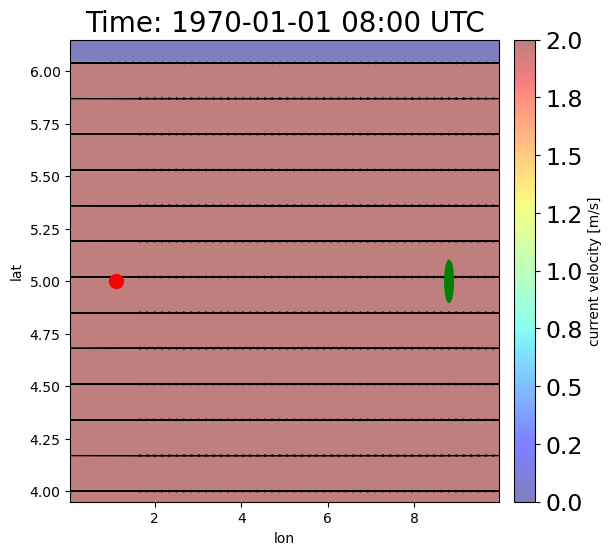

<Figure size 640x480 with 0 Axes>

In [13]:
t_interval, lat_bnds, lon_bnds = arena.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
    x_0=x_0.to_spatio_temporal_point(),
    x_T=x_T,
    deg_around_x0_xT_box=1,
    temp_horizon_in_s=3600*24,
)
ax = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=x_0.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True, quiver_spatial_res=0.17, quiver_scale=6)
problem.plot(ax=ax)
plt.show()
plt.tight_layout()



In [14]:
filename_obstacles = "data/analytical_currents/obstacle.nc"
specific_settings = {
    "replan_on_new_fmrc": True,
    "replan_every_X_seconds": False,
    "direction": "multi-time-reach-back",  # "multi-time-reach-back",
    "n_time_vector": 200,
    "closed_loop": True,
    # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
    "deg_around_xt_xT_box": 1,  # area over which to run HJ_reachability
    "accuracy": "low",
    "artificial_dissipation_scheme": "local_local",
    "T_goal_in_seconds": 3600*24,
    "use_geographic_coordinate_system": True,
    "progress_bar": True,
    "initial_set_radii": [
        0.01,  # 0.1
        0.01,
    ],  # this is in deg lat, lon. Note: for Backwards-Reachability this should be bigger.
    # Note: grid_res should always be bigger than initial_set_radii, otherwise reachability behaves weirdly.
    "grid_res": 0.04,  # 0.02  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
    "d_max": 0.0,
    # 'EVM_threshold': 0.3 # in m/s error when floating in forecasted vs sensed currents
    # 'fwd_back_buffer_in_seconds': 0.5,  # this is the time added to the earliest_to_reach as buffer for forward-backward
    "platform_dict": arena.platform.platform_dict,
    "obstacle_dict": {
        "path_to_obstacle_file":filename_obstacles, #"ocean_navigation_simulator/package_data/bathymetry_and_garbage/bathymetry_distance_res_0.083_0.083_max_elevation_-150.nc",
        "obstacle_value": 1,
        "safe_distance_to_obstacle": 10,
    },
}

In [15]:
planner = HJReach2DPlanner(problem=problem, specific_settings=specific_settings)
observation = arena.reset(platform_state=x_0)
action = planner.get_action(observation=observation)

100%|##########|  1.0000/1.0 [00:03<00:00,  3.65s/sim_s] 
/home/andy/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/hj_reachability/dynamics.py:94: UserWarning:

x_init is not in the Backwards/Forwards Reachable Set/Tube



ValueError: Contour levels must be increasing

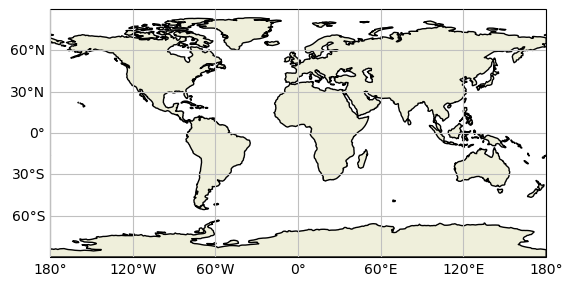

In [16]:
ax = planner.plot_reachability_snapshot(#plot_reachability_snapshot_over_currents(
    rel_time_in_seconds=0,
    granularity_in_h=6,  # 12
    alpha_color=1,
    time_to_reach=True,
    fig_size_inches=(3, 3),
    # plot_in_h=True,
    return_ax=True,
)
plt.show()

In [22]:
np.min(planner.all_values)

DeviceArray(1., dtype=float32)

In [ ]:
for i in tqdm(range(int(specific_settings["T_goal_in_seconds"] / 600))):
    action = planner.get_action(observation=observation)
    observation = arena.step(action)

#%% Animate the trajectory
arena.animate_trajectory(
    add_ax_func_ext=arena.add_ax_func_ext_overlay,
    problem=problem,
    temporal_resolution=7200,)


## Plotting (not needed)

In [ ]:
# For fast interpolation of currents we cache part of the spatio-temporal data around x_t in a casadi function
casadi_cache_dict = {"deg_around_x_t": 1, "time_around_x_t": 3600 * 24 * 1}
#%% Highway current
true_current_source = {
    "field": "OceanCurrents",
    "source": "analytical",
    "source_settings": {
        "name": "FixedCurrentHighway",
        "boundary_buffers": [0.2, 0.2],
        "x_domain": [0, 10],
        "y_domain": [0, 10],
        "temporal_domain": [0, 10],
        "spatial_resolution": 0.1,
        "temporal_resolution": 1,
        "y_range_highway": [4, 6],
        "U_cur": 2,
    },
}
forecast_current_source = {
    "field": "OceanCurrents",
    "source": "analytical",
    "source_settings": {
        "name": "FixedCurrentHighway",
        "boundary_buffers": [0.2, 0.2],
        "x_domain": [0, 10],
        "y_domain": [0, 10],
        "temporal_domain": [0, 10],
        "spatial_resolution": 0.1,
        "temporal_resolution": 1,
        "y_range_highway": [4, 6],
        "U_cur": 8,
    },
}

In [ ]:
#%% Create the ocean Field
ocean_field = OceanCurrentField(
    hindcast_source_dict=true_current_source,
    forecast_source_dict=forecast_current_source,
    casadi_cache_dict=casadi_cache_dict,
    use_geographic_coordinate_system=False,
)
#%% visualize it at a specific time
ocean_field.plot_true_at_time_over_area(
    time=datetime.datetime.fromtimestamp(10, tz=datetime.timezone.utc),
    x_interval=[0, 10],
    y_interval=[0, 10],
)